# Multi-Modal Embeddings

Multi-modal embeddings enable the ability to use input data in formats beyond text, such as images and audio.

### Embed images

Let's try embedding pages of a PDF directly as images with a ColPali family model. This approach is designed to preserve the layout and content of the original document, which is mostly lost during the `docling` preprocessing we used earlier.

**Run this install cell as soon as you begin, as it may take >1min to complete due to the size of the `colpali-engine` library.**

In [1]:
!pip --quiet install colpali-engine==0.3.12 weaviate-client==4.16.10 pydantic==2.11.9


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


Here, we'll download the ColPali model from Hugging Face and optimize it for CPU.

**Instantiate the `"vidore/colSmol-256M"` model using the `ColIdefics3` class and accompanying processor to compute the text and image embeddings.**

In [2]:
import os
import torch
from colpali_engine.models import ColIdefics3, ColIdefics3Processor

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

model = ColIdefics3.from_pretrained(
    "vidore/colSmol-256M",
    torch_dtype=torch.float32,  # use float32 for CPU
    device_map="cpu"            # explicitly use CPU
).eval()

2025-11-06 22:18:19.787036: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762467499.803939    1945 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762467499.808747    1945 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1762467499.821606    1945 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1762467499.821621    1945 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1762467499.821623    1945 computation_placer.cc:177] computation placer alr

Each model also requires a processor to prepare the inputs for embedding generation. This will convert both the text and images into tensors, which is what the model expects to generate shared representations (embeddings) of the two.

In [3]:
processor = ColIdefics3Processor.from_pretrained(
    "vidore/colSmol-256M"
)

processor.image_processor.token_pooling = True
processor.image_processor.size = {"longest_edge": 224}

These are the pages that we'll be embedding from the annual AI Index 2025 report:

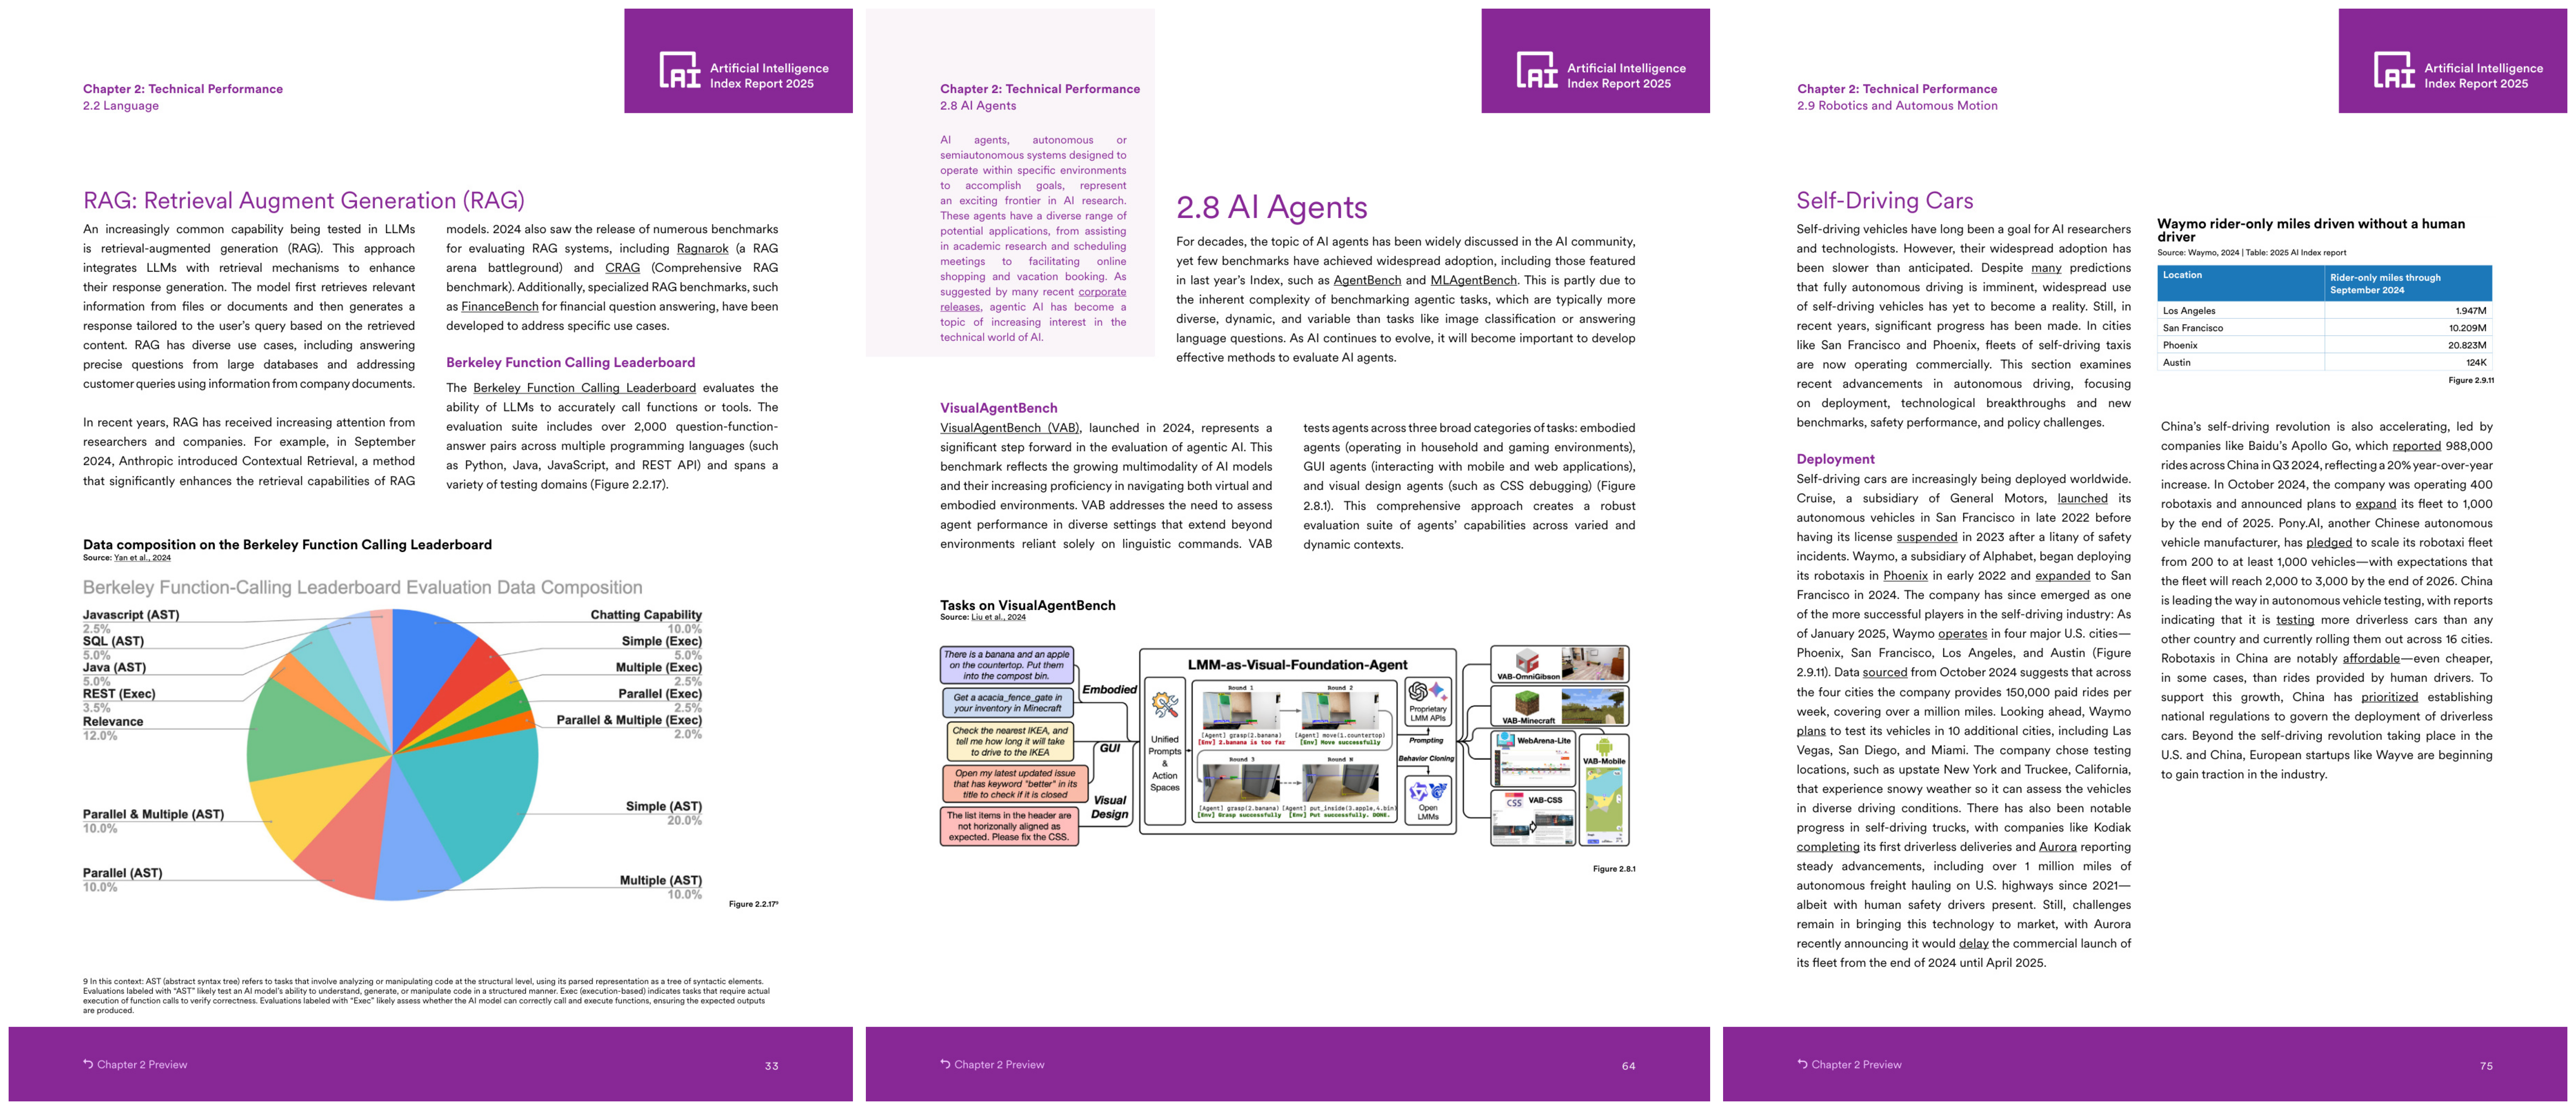

In [4]:
import matplotlib.pyplot as plt
from PIL import Image

fig, axes = plt.subplots(1, 3, figsize=(30, 15))

image_paths = [
    "data/imgs/hai_ai-index-report-2025_chapter2_excerpts_1_of_8.jpg",  # RAG
    "data/imgs/hai_ai-index-report-2025_chapter2_excerpts_4_of_8.jpg",  # AI Agents
    "data/imgs/hai_ai-index-report-2025_chapter2_excerpts_7_of_8.jpg"   # Self-driving cars
]

for i, img_path in enumerate(image_paths):
    img = Image.open(img_path)
    axes[i].imshow(img)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

We'll embed these images here using the `processor` defined earlier, then use the `model` to generate the embeddings.

**Preprocess the image inputs using `processor` and generate the image embeddings using `model()`.**

In [5]:
image_embeddings_list = []
for image_path in image_paths:
    images = [Image.open(image_path)]

    # 🧪 Preprocess inputs
    batch_images = processor.process_images(images).to("cpu")

    # ⚡ Inference
    with torch.no_grad():
        image_embeddings = model(**batch_images)
    image_embeddings_list.append(image_embeddings[0])

all_embeddings = torch.stack(image_embeddings_list)
print(all_embeddings.size())
print(all_embeddings[0][0][:3])

torch.Size([3, 79, 128])
tensor([0.1146, 0.0238, 0.0133])


### Data import

We'll set up a collection where each object is based on a page of a PDF document.

In [6]:
import weaviate
from openai import OpenAI as OpenAIClient

raw_client = OpenAIClient()
API_KEY  = str(raw_client.api_key)
API_BASE = str(raw_client.base_url)

HEADERS = {
    "X-OpenAI-Api-Key": API_KEY,
    "X-OpenAI-BaseURL": API_BASE.rstrip("/").removesuffix("/v1"),
}

try:
    client = weaviate.connect_to_embedded(
        version="1.32.3",
        headers=HEADERS,
        environment_variables={"LOG_LEVEL": "error"},
    )
except weaviate.exceptions.WeaviateStartUpError:
    # If already running, connect to it instead
    client = weaviate.connect_to_local(
        port=8079,
        grpc_port=50050,
        headers=HEADERS,
    )

The vector configuration is set up with: `Configure.MultiVectors.self_provided()`. This specifies that it is a multi-vector embedding model (`Configure.MultiVectors`), and that the vectors will be provided by the user (`.self_provided()`).

**Create and use a collection called `"Pages"` to store the PDF pages and their embeddings.**

In [7]:
from weaviate.classes.config import Property, DataType, Configure

# Delete "Pages" if it's already present to allow repeated runs
if "Pages" in client.collections.list_all():
    client.collections.delete("Pages")

client.collections.create(
    name="Pages",
    properties=[
        Property(
            name="document_title",
            data_type=DataType.TEXT,
        ),
        Property(
            name="page_image",
            data_type=DataType.BLOB,
        ),
        Property(
            name="filename",
            data_type=DataType.TEXT,
        ),
    ],
    vector_config=[
        Configure.MultiVectors.self_provided(name="default")
    ]
)

{"action":"load_all_shards","build_git_commit":"","build_go_version":"go1.24.6","build_image_tag":"","build_wv_version":"1.32.3","level":"error","msg":"failed to load all shards: context canceled","time":"2025-11-06T22:18:46Z"}


In [8]:
pages = client.collections.use("Pages")

To make the process easier, we've pre-generated the embeddings for the pages of the PDF document.

In [9]:
import numpy as np
import json

with open("data/embeddings/embeddings_metadata.json", "r") as f:
    metadata = json.load(f)

embeddings = np.load("data/embeddings/image_embeddings.npy")
print(embeddings.shape)
print(embeddings[0][0][:3])

(8, 1139, 128)
[0.11474609 0.02355957 0.01293945]


**Add the image embeddings to the `"Pages"` collection, assigned to `pages`, and close the connection to the client.**

In [10]:
from tqdm import tqdm
from pathlib import Path
import base64
from weaviate.util import generate_uuid5

with pages.batch.fixed_size(batch_size=100) as batch:
    for i, embedding in tqdm(enumerate(embeddings)):
        filepath = Path(metadata["image_paths"][i])
        image = filepath.read_bytes()
        base64_image = base64.b64encode(image).decode('utf-8')
        obj = {
            "document_title": "Stanford AI Index Report 2025",
            "page_image": base64_image,
            "filename": filepath.name
        }

        # Add object to batch for import with (batch.add_object())
        # This time, manually provide the vector with `{"default": embedding}`
        batch.add_object(
            properties=obj,
            uuid=generate_uuid5(str(filepath)),
            vector={"default": embedding}
        )

8it [00:00, 30.06it/s]


### Close the client

Remember to close the client library connection and Weaviate.

In [11]:
client.close()

{"build_git_commit":"","build_go_version":"go1.24.6","build_image_tag":"","build_wv_version":"1.32.3","error":"cannot find peer","level":"error","msg":"transferring leadership","time":"2025-11-06T22:18:51Z"}
